In [1]:
!pip install sqlalchemy
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
#engine = create_engine(r"C:\Users\nawri\OneDrive\Desktop\mod 10 challenge\Starter_Code\Resources\hawaii.sqlite")

In [5]:
# Import the necessary modules from SQLAlchemy
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Specify the path to your SQLite database file
database_path = r"C:\Users\nawri\OneDrive\Desktop\mod 10 challenge\Starter_Code\Resources\hawaii.sqlite"

# Create an engine that connects to the SQLite database
engine = create_engine(f"sqlite:///{database_path}")

# Reflect the existing database into a new model
Base = automap_base()

# Reflect the tables from the database
Base.prepare(engine, reflect=True)

# Now you can reference the tables that were reflected from the database
# For example, if there was a table called 'measurement' in the database:
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session to interact with the database
session = Session(engine)

# Example query using SQLAlchemy to get the first row from the 'measurement' table
first_measurement = session.query(Measurement).first()
print(first_measurement)



C:\Users\nawri\AppData\Local\Temp\ipykernel_6428\938282019.py:17: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement  
Station = Base.classes.station          

In [8]:
first_measurement = session.query(Measurement).first()
first_measurement

In [9]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


The most recent date in the dataset is: 2017-08-23


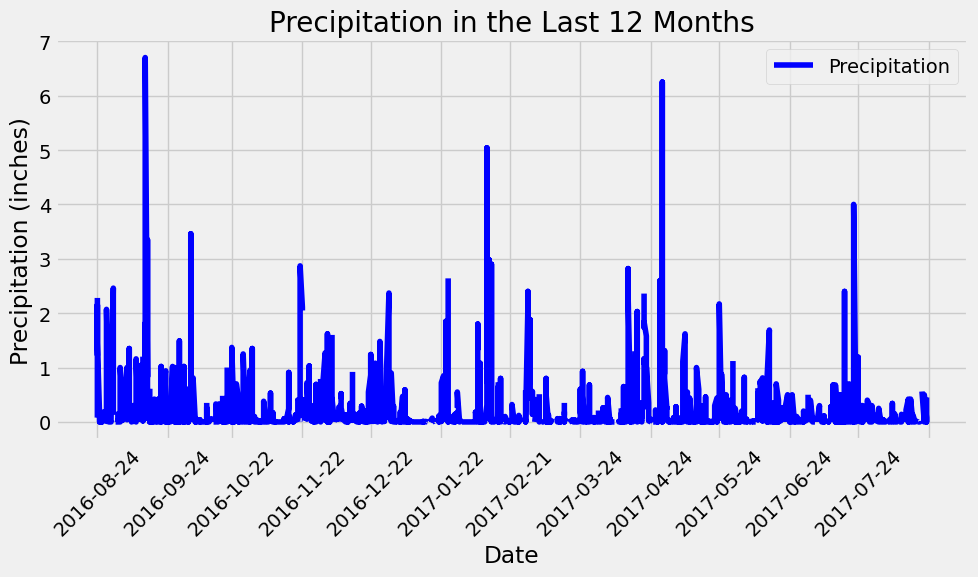

In [11]:
from datetime import datetime, timedelta
# Step 1: Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the dataset is: {most_recent_date}")

# Calculate the date one year from the most recent date
most_recent_datetime = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_datetime - timedelta(days=365)

# Step 2: Query the last 12 months of precipitation data
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Step 3: Save the query results as a Pandas DataFrame
# Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Step 4: Sort the DataFrame by date
precipitation_df.sort_values(by='Date', inplace=True)

# Step 5: Plot the data using Pandas and Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], color='b', label='Precipitation')

# Set x-axis major locator to a month and formatter to display the month and year
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in the Last 12 Months')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
precipitation_df.shape

(2223, 2)

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
ds = pd.DataFrame(precipitation_df['Precipitation'].describe())
ds

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
from sqlalchemy import func

# Query to count the total number of stations
total_stations = session.query(func.count(Station.id)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Query to find the most active stations
most_active_stations = (
    session.query(
        Measurement.station,
        func.count(Measurement.station).label('count')
    )
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Print stations and their counts in descending order
for station, count in most_active_stations:
    print(f"Station ID: {station}, Count: {count}")


Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

# Query to find the lowest, highest, and average temperature
temp_stats = (
    session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)

# Print temperature statistics
min_temp, max_temp, avg_temp = temp_stats[0]
print(f"Lowest temperature: {min_temp}")
print(f"Highest temperature: {max_temp}")
print(f"Average temperature: {avg_temp}")

Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


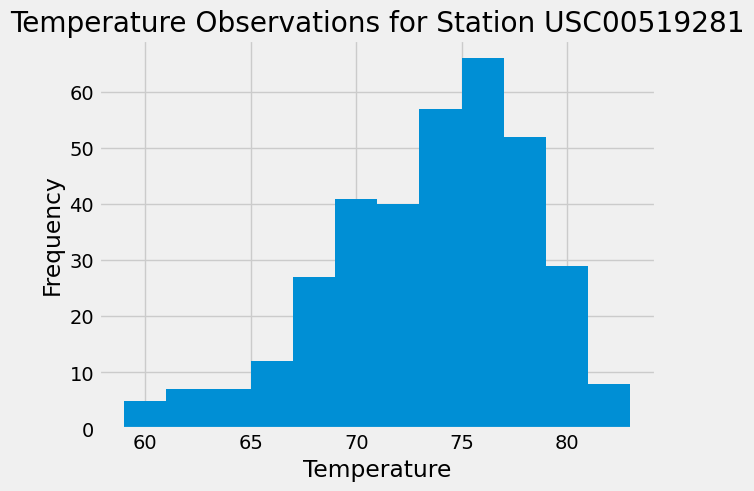

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Calculate the date 12 months ago from the most recent date in the dataset
# Get the most recent date
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date = datetime.strptime(recent_date, '%Y-%m-%d')
start_date = recent_date - timedelta(days=365)

# Query to get temperature observations for the last 12 months
temps_last_12_months = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= start_date)
    .all()
)

# Extract temperature values
temperatures = [temp[0] for temp in temps_last_12_months]

# Plot histogram
plt.hist(temperatures, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station_id}')
plt.show()


# Close Session

In [19]:
# Close Session
session.close()